### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [1]:
#pip install timm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#pip install open3d

     |████████████████████████████████| 408.6 MB 22 kB/s 
     |████████████████████████████████| 8.7 MB 44.0 MB/s 
     |████████████████████████████████| 596 kB 37.8 MB/s 
     |████████████████████████████████| 4.3 MB 27.0 MB/s 
     |████████████████████████████████| 1.1 MB 43.4 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 342 kB 49.2 MB/s 
     |████████████████████████████████| 428 kB 59.7 MB/s 
     |████████████████████████████████| 1.1 MB 51.9 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 130 kB 58.0 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 561 kB 57.1 MB/s 
     |████████████████████████████████| 133 kB 57.9 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client

### Example Usage

Download an image from the PyTorch homepage

In [2]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

import time
import numpy as np
import open3d as o3d
#url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
#urllib.request.urlretrieve(url, filename)
filename = '/home/joonsu0109/ComputerVision/MonocularDepth/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402945162460.jpg'

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [2]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/joonsu0109/.cache/torch/hub/intel-isl_MiDaS_master


Move model to GPU if available

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (dro

Load transforms to resize and normalize the image for large or small model

In [4]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/joonsu0109/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [5]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

Predict and resize to original resolution

In [6]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()


/home/joonsu0109/enter/envs/dev/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [7]:
Q = np.array(([1.0, 0.0, 0.0, -160.0],
              [0.0, 1.0, 0.0, -120.0],
              [0.0, 0.0, 0.0, 350.0],
              [0.0, 0.0, 1.0/90.0, 0.0]),dtype=np.float32)

In [8]:
np.shape(output)

(900, 1600)

In [9]:
depth_map = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
np.shape(depth_map)


(900, 1600)

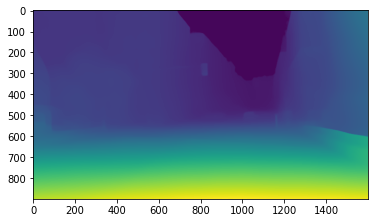

In [10]:
plt.imshow(depth_map)

In [11]:
points_3D = cv2.reprojectImageTo3D(depth_map, Q, handleMissingValues=False)
np.shape(points_3D)

(900, 1600, 3)

In [12]:
points_3D[0, 0, :]

array([-94449.71, -70837.28, 206608.75], dtype=float32)

In [13]:
mask_map = depth_map > 0.4
np.shape(mask_map)

(900, 1600)

In [14]:
np.shape(points_3D)

(900, 1600, 3)

In [15]:
#xyz
output_points = points_3D[mask_map]
np.shape(output_points)


(438587, 3)

In [16]:
output_points

array([[280340.6  , 100571.625,  78747.36 ],
       [280271.   , 100466.03 ,  78664.68 ],
       [280210.03 , 100363.695,  78584.55 ],
       ...,
       [133146.3  ,  72178.82 ,  32429.51 ],
       [133319.9  ,  72222.68 ,  32449.213],
       [133449.19 ,  72242.48 ,  32458.107]], dtype=float32)

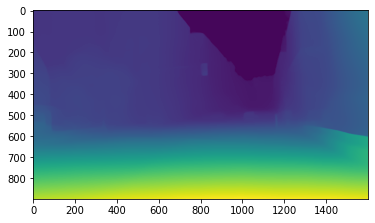

In [17]:
depth_map = (depth_map*255).astype(np.uint8)
np.shape(depth_map)
plt.imshow(depth_map)

In [18]:
#rgb
output_colors = img[mask_map]
np.shape(output_colors)

(438587, 3)

In [19]:
output_colors

array([[ 89,  94, 100],
       [ 86,  94,  97],
       [ 79,  93,  93],
       ...,
       [ 98, 100,  99],
       [ 97,  99,  98],
       [ 94,  96,  95]], dtype=uint8)

In [20]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


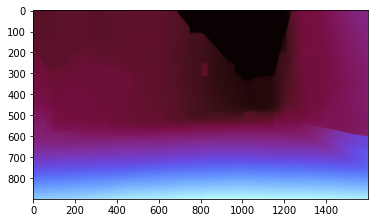

In [21]:
depth_map = cv2.applyColorMap(depth_map , cv2.COLORMAP_MAGMA)
plt.imshow(depth_map)

In [22]:
cv2.imwrite('depth_test.jpg', depth_map)

True

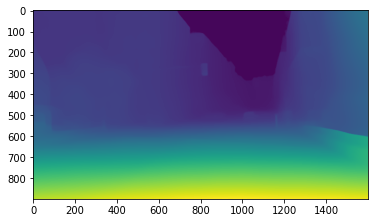

In [52]:
depth_map = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(depth_map)

In [ ]:
#depth를 point로 만들기 위한 projection 및 색상 추출
'''
depth_map = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) # 보다 부드럽게 
points_3D = cv2.reprojectImageTo3D(depth_map, Q, handleMissingValues=False) # xyz 정보 받기
mask_map = depth_map > 0.4  # 쓸모 없는 point 없애기위한 mask map 생성
output_points = points_3D[mask_map]
output_colors = img[mask_map]   # 포인트에 RGB데이터를 넣기 위함
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # BGR 포멧으로 변경
depth_map = (depth_map*255).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
'''


Show result

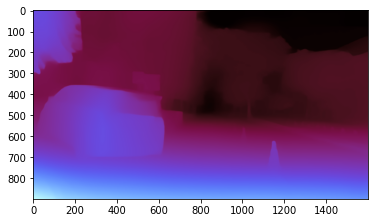

In [ ]:
plt.imshow(depth_map)
# plt.show()

In [33]:
#ply파일로 point cloud 변환
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
        #pcd = o3d.io.read_point_cloud("js_pointCloudDeepLearning.ply")
        #o3d.io.write_point_cloud("js_pointCloudDeepLearning.pcd", pcd)
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [ ]:
output_file = 'js_pointCloudDeepLearning.ply'
create_output(output_points, output_colors, output_file)

In [34]:
output_file = 'test.ply'
create_output(output_points, output_colors, output_file)

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models: